In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle

plt.rcParams['axes.facecolor'] = 'lightgrey'
sns.set(palette='Set2', font_scale=1.6)

### Задача 5.2

*Внимание!* Перед выполнением задачи прочитайте полностью условие. В задаче используются смеси различных моделей с разными гиперпараметрами. Подумайте над тем, какой гиперпараметр как подбирать и на каком множестве. Не забудьте, что на тестовой выборке, по которой делаются итоговые выводы, ничего не должно обучаться.

**1.** Повторите исследование, проведенное в задаче 2 предыдущего домашнего задания, используя градиентный бустинг из `sklearn`. Сравните полученные результаты со случайным лесом. Детали:
* в качестве основы можно использовать как свое решение предыдущего задания, так и выложенное на Вики. В большинстве случаев нужно только заменить `RandomForestRegressor` на `GradientBoostingRegressor`.
* у градиентного бустинга есть также важный гиперпараметр `learning_rate`. Поясните его смысл и проведите аналогичные исследования.
* при сравнении методов по одинаковым свойствам желательно рисовать результаты на одном графике.
* обратите внимание на метод `staged_predict` у `GradientBoostingRegressor`. Он позволяет получить "кумулятивные" предсказания, то есть по первым $t$ деревьям по всем значениям $t$.
* при кросс-валидации проводите достаточное количество итераций рандомизированного поиска (при $\geqslant 2$ параметров) на большой сетке параметров. Даже если долго обучается.

**2.** Выберите самый значимый признак согласно `feature_importances_` и визуализируйте работу первых 10 деревьев на графиках зависимости таргета от этого признака. Пример графиков смотрите в лекции.

**3.** Обучите градиентный бустинг на решающих деревьях, у которого в качестве инициализирующей модели используется линейная регрессия. Для этого используйте класс `GradientBoostingRegressor`, которому при инициализации в качестве параметра `init` передайте модель ридж-регрессии Ridge, которая должна быть инициализирована, но необучена. Подберите оптимальные гиперпараметры такой композиции. Как вы будете подбирать гиперпараметр ридж-регрессии? Улучшилось ли качество модели на тестовой выборке?

**4.** Рассмотрим модели смеси градиентного бустинга $\widehat{y}_{gb}$ и случайного леса $\widehat{y}_{rf}$ в виде
$$\widehat{y}(x) = w \widehat{y}_{gb}(x) +  (1-w) \widehat{y}_{rf}(x),$$
где $w \in [0, 1]$ --- коэффициент усреднения. Подберите оптимальное значение гиперпараметра $w$. Удалось ли добиться улучшения качества на тестовой выборке?

### Повтор исследования и сравнение со случайным лесом

В качестве данных возьмём датасет `california_housing` из библиотеки `sklearn` о стоимости недвижимости в различных округах Калифорнии. Этот датасет состоит из 20640 записей и содержит следующие признаки для каждого округа: `MedInc`, `HouseAge`, `AveRooms`, `AveBedrms`, `Population`, `AveOccup`, `Latitude`, `Longitude`. `HouseAge` и `Population` - целочисленные признаки. Остальные признаки - вещественные.

*Совет.* При отладке кода используйте небольшую часть данных. Финальные вычисления проведите на полных данных. Для оценки времени работы используйте `tqdm` в циклах.

In [2]:
housing = fetch_california_housing()
X, y = housing.data, housing.target

In [3]:
X.shape

(20640, 8)

Разобьём данные на обучающую выборку и на валидацию, выделив на валидацию 25% данных.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

Посмотрите, как изменяется качество предсказаний градиентного бустинга в зависимости от выбранных параметров. Для этого постройте графики зависимости MSE на тестовой выборке от количества деревьев и от максимальной глубины дерева. Когда варьируете один из параметров, для другого берите значение по умолчанию.

**Построение зависимости MSE от количества деревьев**

Вспомогательная функция

In [5]:
def plot_dependence_test(param_grid, test_values, param_label,
                         metrics_label, title):
    '''
    Функция для построения графиков зависимости целевой метрики 
    от некоторого параметра модели на валидационной выборке.
    
    Параметры.
    1) param_grid - значения исследуемого параметра,
    2) test_values - значения метрики на валидационной выборке,
    3) param_label - названия параметра,
    4) metrics_label - название метрики,
    5) title - заголовок для графика.
    '''
    
    plt.figure(figsize=(12, 6))
    plt.plot(param_grid, test_values, label='тестовая выборка', linewidth=4)
   
    plt.xlabel(param_label)
    plt.ylabel(metrics_label)
    plt.legend()
    plt.title(title)
    plt.show()

Вычисления и построение графика

In [6]:
mse_values = []
n_estimators_grid = range(1, 300)
regressor = GradientBoostingRegressor(
    n_estimators=max(list(n_estimators_grid))
)
regressor.fit(X_train, y_train)
staged_predictions = regressor.staged_predict(X_test)

mse_values = [mse(prediction, y_test) for prediction in staged_predictions]

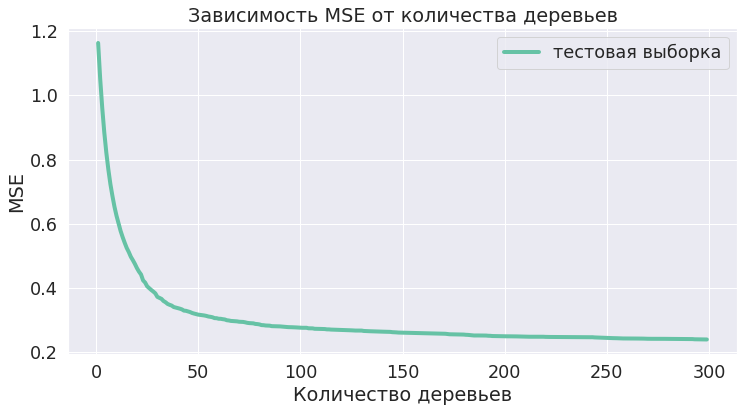

In [7]:
plot_dependence_test(n_estimators_grid, mse_values, 
                     'Количество деревьев', 'MSE', 
                     'Зависимость MSE от количества деревьев')

Как и при использовании случайного леса, ошибка на тестовой выборке монотонно убывает. Но если в лесе при `n_estimators`, близком к 100, `mse` практически переставала уменьшаться, то в градиентном бустинге эта разница выглядит более существенной. 

**Построение зависимости MSE от максимальной глубины**

In [8]:
mse_values = []

for max_depth in tqdm(range(3, 15)):
    regressor = GradientBoostingRegressor(max_depth=max_depth, 
                                          n_estimators=300)
    regressor.fit(X_train, y_train)
    predictions = regressor.predict(X_test)
    mse_values.append(mse(predictions, y_test))

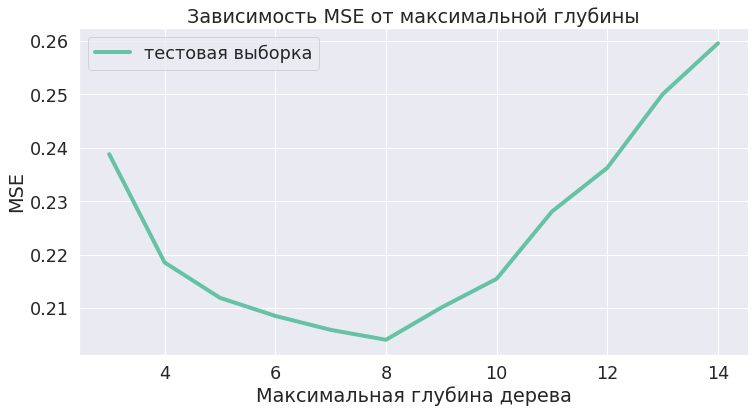

In [9]:
plot_dependence_test(np.arange(3, 15), mse_values, 
                     'Максимальная глубина дерева', 'MSE', 
                     'Зависимость MSE от максимальной глубины')

Посмотрим, что будет происходить при меньших значениях `n_estimators`.

In [10]:
mse_values = []

for max_depth in tqdm(range(3, 15)):
    regressor = GradientBoostingRegressor(max_depth=max_depth, 
                                          n_estimators=50)
    regressor.fit(X_train, y_train)
    predictions = regressor.predict(X_test)
    mse_values.append(mse(predictions, y_test))

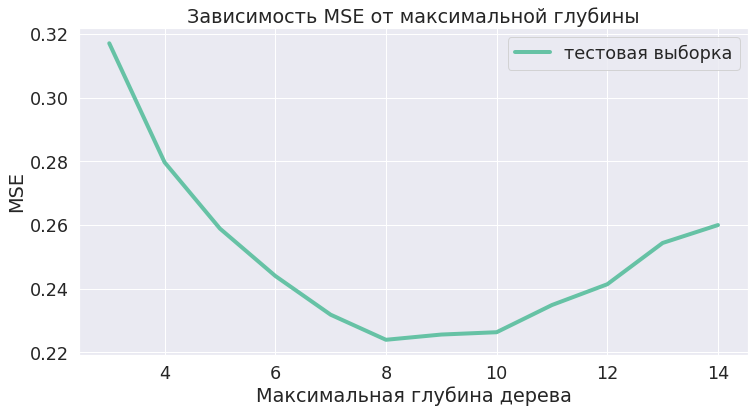

In [11]:
plot_dependence_test(np.arange(3, 15), mse_values, 
                     'Максимальная глубина дерева', 'MSE', 
                     'Зависимость MSE от максимальной глубины')

**Построение зависимости MSE от значения `learning rate`**

Как мы видим, в отличие от случайного леса, при использовании градиентного бустинга стоит ограничивать глубину дерева, поскольку на каждой итерации бустинг уменьшает смещение (bias) итоговой модели, а не дисперсию.

In [36]:
mse_values = []

for lr in tqdm(np.linspace(0.05, 0.7, 700)):
    regressor = GradientBoostingRegressor(learning_rate=lr, 
                                          n_estimators=300)
    regressor.fit(X_train, y_train)
    predictions = regressor.predict(X_test)
    mse_values.append(mse(predictions, y_test))

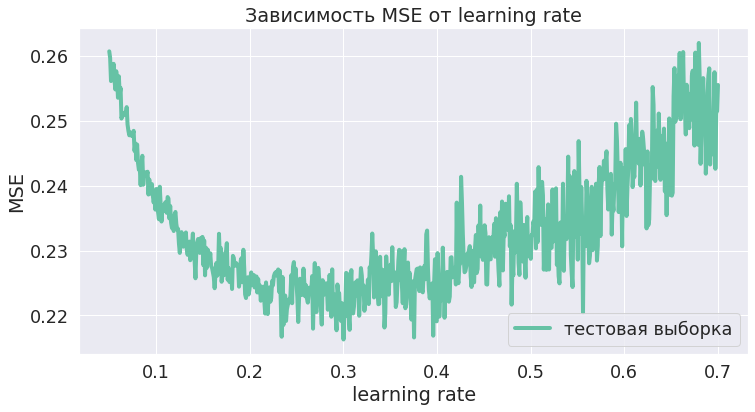

In [37]:
plot_dependence_test(np.linspace(0.05, 0.7, 700), mse_values, 
                     'learning rate', 'MSE', 
                     'Зависимость MSE от learning rate')

Оптимальное значение `learning rate` близко к 0.3.

Основываясь на полученных графиках, ответьте на следующие вопросы.

1. Какие закономерности можно увидеть на построенных графиках? Почему графики получились такими?

2. Как изменяется качество предсказаний с увеличением исследуемых параметров, когда эти параметры уже достаточно большие.

3. В предыдущем задании вы на практике убедились, что решающее дерево начинает переобучаться при достаточно больших значениях максимальной глубины. Справедливо ли это утверждение для решающего леса? Поясните свой ответ, опираясь на своё знание статистики.

**Вывод.**

По первому графику можно сделать вывод, что с возрастанием числа использованных деревьев используется, MSE снижается. Но при достаточно больших значениях `n_estimators` значение MSE практически перестаёт меняться. Здесь получается похожая ситуация, что и при использовании случайного леса. Однако "пороговое" значение `n_estimators` выше.


С параметром `max_depth` ситуация не такая, как при использовании случайного леса. Существует пороговое значение `max_depth`, выше которого модель имеет слишком высокую дисперсию и потому `mse` повышается. Отсюда можно сделать предположение, что градиентный бустинг имеет более высокую дисперсию, чем случайный лес, но более низкое смещение.

Параметр `learning_rate` стоит подбирать аккуратно. Надо сделать его достаточно большим, чтобы градиентный спуск быстро сходился и не застревал в точках, близких к локальным минимумам, но при этом не расходился.

Обучите градиентный бустинг со значениями гиперпараметров по умолчанию и выведите mse на тестовой выборке. Проведите эксперимент 3 раза. Почему результаты почти не отличаются?

In [14]:
for iteration in tqdm(range(3)):
    regressor = GradientBoostingRegressor(n_estimators=100)
    regressor.fit(X_train, y_train)
    predictions = regressor.predict(X_test)
    print('MSE = {:.4f}'.format(mse(predictions, y_test)))

MSE = 0.2765
MSE = 0.2764
MSE = 0.2764



**Ответ.**

Результаты слабо отличаются, потому что единственный источник случайности здесь -- случайная перестановка признаков в цикле для разбиения вершины. Если при разбиении вершины существуют два разделяющихся признака, которые дают одинаковое значение критерия информативности, то из них выбирается тот, что первым перебирается в цикле.

**Подбор гиперпараметров градиентного бустинга**

Было бы неплохо определиться с тем, какое количество деревьев нужно использовать и какой максимальной глубины они будут. Подберите оптимальные значения `max_depth` и `n_estimators` с помощью кросс-валидации.

In [15]:
gb_gridsearch = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(), 
    param_distributions={
        'max_depth': np.arange(3, 30), 
        'n_estimators': np.arange(10, 200),
        'learning_rate': np.linspace(0.05, 0.3, 300)
    },
    cv=5,  # разбиение выборки на 5 фолдов
    verbose=10,  # насколько часто печатать сообщения
    n_jobs=2,  # кол-во параллельных процессов
    n_iter=20  # кол-во итераций случайного выбора гиперпараметров
)

In [16]:
gb_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    3.8s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   50.0s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  2.6min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  3.4min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  4.4min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  5.1min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  8.4min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:  9.3min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  9.9min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed: 13.1min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed: 15.0min
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed: 15.6min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=GradientBoostingRegressor(alpha=0.9,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                            

Выведите найденные оптимальные параметры.

In [17]:
print(gb_gridsearch.best_params_)

{'n_estimators': 194, 'max_depth': 5, 'learning_rate': 0.15451505016722408}


Зафиксируем эти оптимальные значения параметров и будем их использовать в дальнейшем.

In [18]:
max_depth = gb_gridsearch.best_params_['max_depth']
n_estimators = gb_gridsearch.best_params_['n_estimators']

Оценим качество предсказаний обученного градиентного бустинга.

In [19]:
predictions = gb_gridsearch.best_estimator_.predict(X_test)
print('{:.4f}'.format(mse(predictions, y_test)))

0.2143


**Зависимость MSE от количества признаков**

Исследуйте зависимость метрики `mse` от количества признаков, по которым происходит разбиение в вершине дерева. Поскольку количество признаков в датасете не очень большое (их 8), то можно перебрать все возможные варианты количества признаков, использующихся при разбиении вершин.

Не забывайте делать пояснения и выводы!

In [20]:
learning_rate = gb_gridsearch.best_params_['learning_rate']

In [21]:
mse_train_values = []
mse_test_values = []

for n_features in tqdm(range(1, 9)):
    rf_regressor = GradientBoostingRegressor(max_depth=max_depth, 
                                         n_estimators=n_estimators,
                                         learning_rate=learning_rate, 
                                         max_features=n_features)
    rf_regressor.fit(X_train, y_train)
    current_train_mse = mse(rf_regressor.predict(X_train), y_train)
    current_test_mse = mse(rf_regressor.predict(X_test), y_test)
    print('n_features: {}, train_mse: {:.4f}, test_mse: {:.4f}'.format(
        n_features, current_train_mse, current_test_mse
    ))
    mse_train_values.append(current_train_mse)
    mse_test_values.append(current_test_mse)

n_features: 1, train_mse: 0.1479, test_mse: 0.2400
n_features: 2, train_mse: 0.1222, test_mse: 0.2188
n_features: 3, train_mse: 0.1129, test_mse: 0.2158
n_features: 4, train_mse: 0.1054, test_mse: 0.2087
n_features: 5, train_mse: 0.1087, test_mse: 0.2144
n_features: 6, train_mse: 0.1061, test_mse: 0.2127
n_features: 7, train_mse: 0.1061, test_mse: 0.2211
n_features: 8, train_mse: 0.1039, test_mse: 0.2152



Постройте график зависимости метрики mse на `test` и `train` от числа признаков, использующихся при разбиении каждой вершины.

In [22]:
def plot_dependence(param_grid, train_values, test_values, 
                    param_label='', metrics_label='', title='',
                    train_label='обучающая выборка', 
                    test_label='тестовая выборка', 
                    create_figure=True):
    '''
    Функция для построения графиков зависимости целевой метрики 
    от некоторого параметра модели на обучающей и на валидационной 
    выборке.
    
    Параметры.
    1) param_grid - значения исследуемого параметра,
    2) train_values - значения метрики на обучающей выборке,
    3) test_values - значения метрики на валидационной выборке,
    4) param_label - названия параметра,
    5) metrics_label - название метрики,
    6) title - заголовок для графика,
    7) create_figure - флаг, устанавливающий нужно ли создавать 
    новую фигуру для графика.
    '''
    
    if create_figure:
        plt.figure(figsize=(12, 6))
    plt.plot(param_grid, train_values, label=train_label, linewidth=3)
    plt.plot(param_grid, test_values, label=test_label, linewidth=3)
       
    plt.legend()
    if create_figure:
        plt.xlabel(param_label)
        plt.ylabel(metrics_label)
        plt.title(title, fontsize=20)

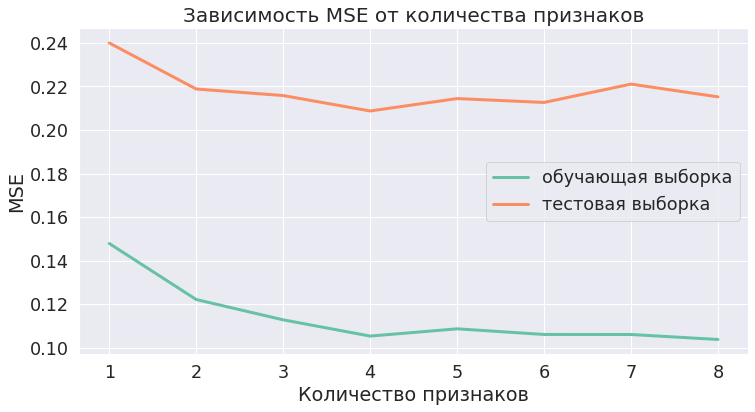

In [23]:
plot_dependence(range(1, 9), mse_train_values, mse_test_values, 
                'Количество признаков', 'MSE', 
                'Зависимость MSE от количества признаков')

Почему график получился таким? Как зависит разнообразие деревьев от величины `max_features`?

**Вывод.**

Чем больше значение `max_features`, тем меньше разнообразие деревьев. Когда `max_features` равно количеству признаков в датасете, градиентный бустинг перестаёт быть случайным. Как мы помним, при использовании случайного леса с некоторого значения `max_features` ошибка MSE начинала расти.

### Визуализация наиболее значимого признака

Для определения наиболее значимого признака, обучим бустинг с оптимальными гиперпараметрами.

In [24]:
gb_regressor = GradientBoostingRegressor(
    max_depth=max_depth, n_estimators=n_estimators, 
    learning_rate=learning_rate
)

gb_regressor.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.15451505016722408, loss='ls',
                          max_depth=5, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=194,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Важности признаков

In [25]:
gb_regressor.feature_importances_

array([0.54720802, 0.04669553, 0.0326843 , 0.01439739, 0.01365882,
       0.12954587, 0.10397711, 0.11183297])

Первый признак (`MedInc`) оказался наиболее значимым.

Обучим градиентный бустинг для построения зависимости целевой переменной от `MedInc`.

In [26]:
gb_regressor = GradientBoostingRegressor(n_estimators=10)
gb_regressor.fit(X_train[:, [0]], y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=10,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Визуализируем построенные деревья.

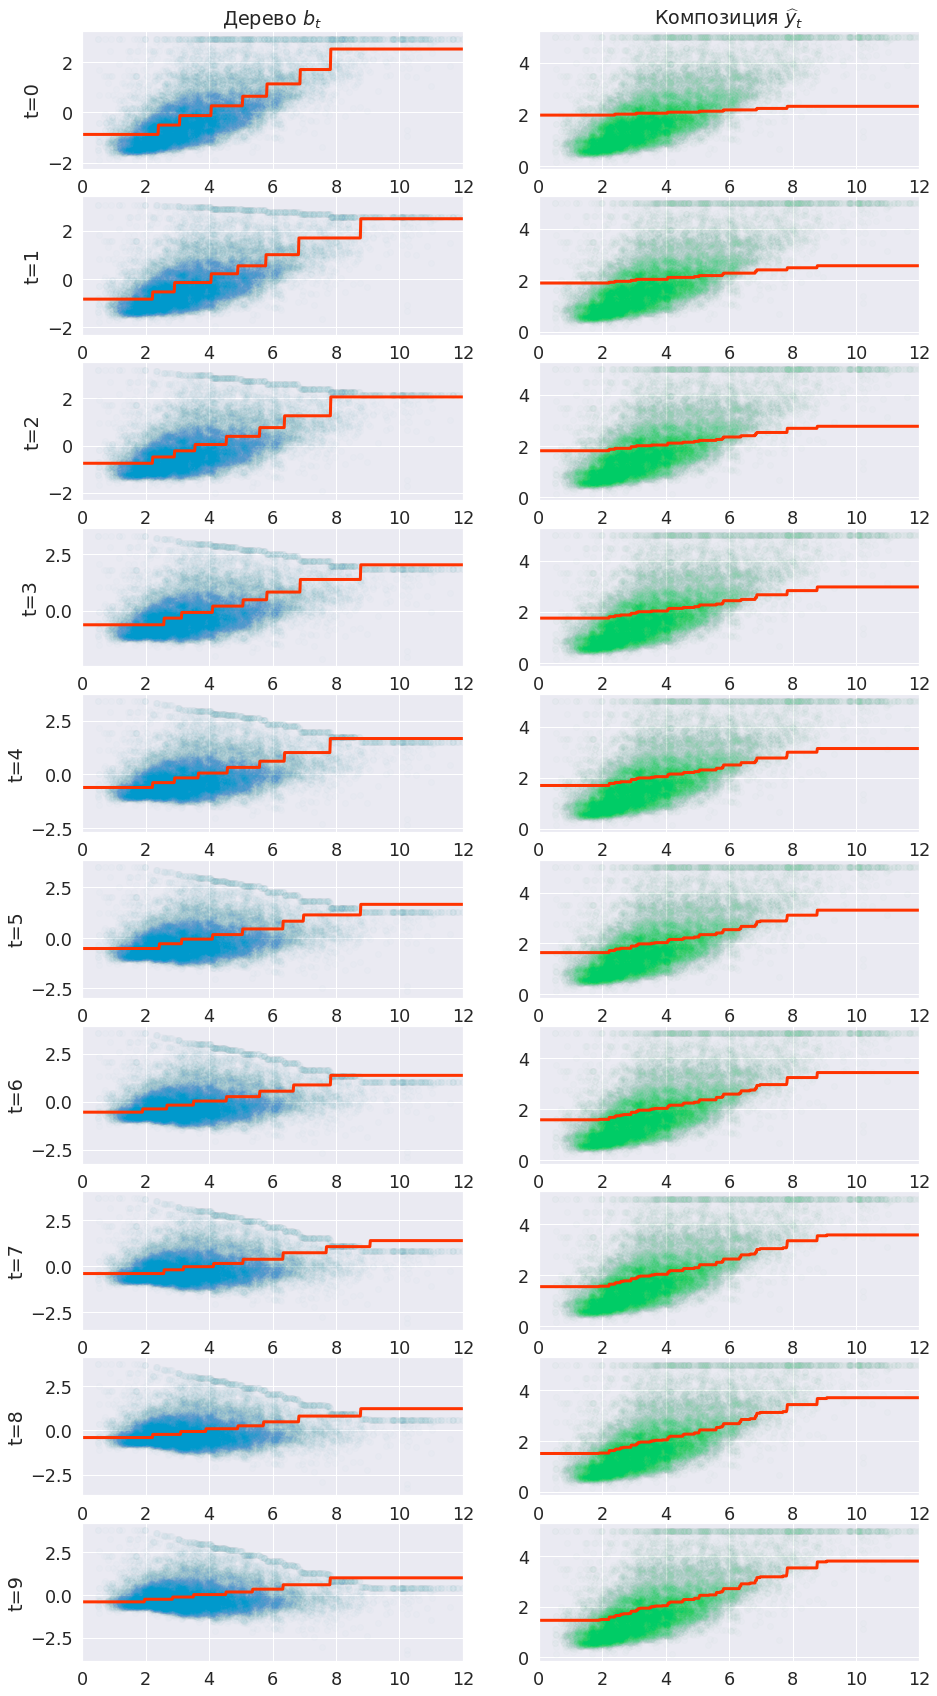

In [27]:
grid = np.linspace(0, np.max(X_train[:, 0]), 1000)
staged_predicts = list(
    gb_regressor.staged_predict(grid.reshape((-1, 1)))
)
residuals = y_train

fig, ax = plt.subplots(10, 2, figsize=(15, 30))
for i in range(10):
    ax[i, 0].plot(
        grid, gb_regressor.estimators_[i, 0].predict(grid.reshape((-1, 1))), 
        linewidth=3, color='#FF3300'
    )
    ax[i, 1].plot(grid, staged_predicts[i], linewidth=3, color='#FF3300')
    ax[i, 0].scatter(X_train[:, 0], residuals - y_train.mean(), 
                     color='#0099CC', alpha=0.01)
    ax[i, 1].scatter(X_train[:, 0], y_train[:], color='#00CC66', alpha=0.01)
    ax[i, 0].set_ylabel(f't={i}')
    
    ax[i, 0].set_xlim((0, 12))
    ax[i, 1].set_xlim((0, 12))
    
    residuals -= learning_rate * gb_regressor.estimators_[i, 0].predict(X_train[:, [0]])

ax[0, 0].set_title('Дерево $b_t$')
ax[0, 1].set_title('Композиция $\\widehat{y}_t$')
plt.show()

**Вывод.**

По графику видно, что с возрастанием числа деревьев х композиция становится более гладкой и лучше приближает обучающую выборку.

### Замена инициализирующей модели

Посмотрим на то, какие параметры есть у градиентного бустинга, который инициализируется с помощью линейной регрессии.

In [45]:
gb_ridge_regressor = GradientBoostingRegressor(init=Ridge())
print(gb_ridge_regressor.get_params())

{'alpha': 0.9, 'criterion': 'friedman_mse', 'init__alpha': 1.0, 'init__copy_X': True, 'init__fit_intercept': True, 'init__max_iter': None, 'init__normalize': False, 'init__random_state': None, 'init__solver': 'auto', 'init__tol': 0.001, 'init': Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), 'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'presort': 'auto', 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


К параметру `alpha` Ridge-регрессии нужно обращаться через имя `init__alpha`. Не путать с `alpha`, являющимся гиперпараметром самого градиентого бустинга!

In [47]:
gb_ridge_gridsearch = RandomizedSearchCV(
    estimator=gb_ridge_regressor, 
    param_distributions={
        'max_depth': np.arange(3, 7), 
        'n_estimators': np.arange(10, 300),
        'learning_rate': np.linspace(0.05, 0.3, 300),
        'init__alpha': np.linspace(0, 5, 501)
    },
    cv=5,  # разбиение выборки на 5 фолдов
    verbose=2,  # насколько часто печатать сообщения
    n_jobs=-1,  # кол-во параллельных процессов
    n_iter=1000  # кол-во итераций случайного выбора гиперпараметров
)

Обучим кросс-валидацию.

In [48]:
gb_ridge_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 22.8min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 32.2min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 42.1min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 52.0min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 65.2min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed: 66.4min finished
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.78491e-08): result may not be accurate.
 

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=GradientBoostingRegressor(alpha=0.9,
                                                       criterion='friedman_mse',
                                                       init=Ridge(alpha=1.0,
                                                                  copy_X=True,
                                                                  fit_intercept=True,
                                                                  max_iter=None,
                                                                  normalize=False,
                                                                  random_state=None,
                                                                  solver='auto',
                                                                  tol=0.001),
                                                       learning_rate=0.1,
                                                       loss='ls', max_d

Оптимальные значения гиперпараметров

In [49]:
print(gb_ridge_gridsearch.best_params_)

{'n_estimators': 238, 'max_depth': 6, 'learning_rate': 0.10434782608695653, 'init__alpha': 3.89}


Оптимальное качество по MSE

In [50]:
mse(gb_ridge_gridsearch.predict(X_test), y_test)

0.21245963246239333

**Вывод.**

Удалось немного улучшить качество на тестовой выборке. Отсюда можно сделать вывод, что при работе с градиентным бустингом может быть полезно попробовать разные инициализирующие модели.

### Смесь бустинга и решающего леса

Обучим модели градиентного бустинга с подобранными ранее гиперпараметрами и случайного леса.

In [33]:
regressor1 = GradientBoostingRegressor(
    max_depth=max_depth, n_estimators=n_estimators,
    learning_rate=learning_rate
)
regressor2 = RandomForestRegressor(
    n_estimators=200
)
regressor1.fit(X_train, y_train)
regressor2.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

Подберем оптимальный вес для смеси моделей

In [34]:
mse_values = []
preds_boosting = regressor1.predict(X_test)
preds_forest = regressor2.predict(X_test)

for w in np.linspace(0, 1, 101):
    predictions = w * preds_boosting + (1 - w) * preds_forest
    mse_values.append(mse(predictions, y_test))

Построим график зависимости mse от коэффициента смеси `w`.

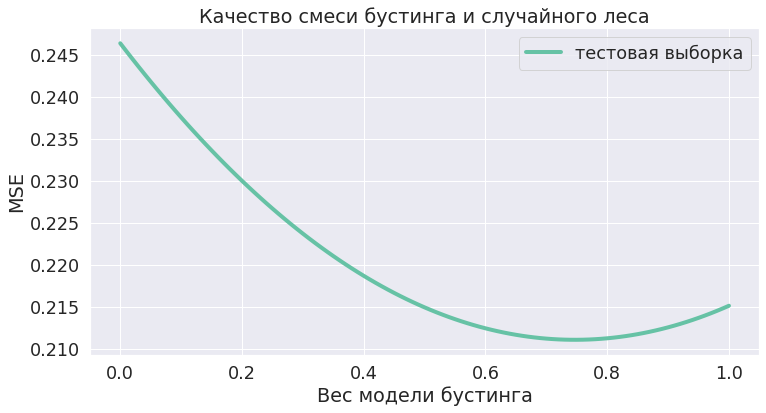

In [35]:
plot_dependence_test(np.linspace(0.0, 1.0, 101), mse_values, 
                'Вес модели бустинга', 'MSE', 
                'Качество смеси бустинга и случайного леса')

**Вывод.**

Использование смеси градиентного бустинга и решающего леса со значением $w \approx 0.7$ позволило получить более точный результат, чем в случае использования чистого бустинга.